# Chapter 17: Deep Q-Learning


New versions of MAC iOS doesn't support OpenGL, which means we need a workaround whenever the OpenAI Gym creates a game window. If you are using MAC, you can use this notebook for Chapter 17.

In [1]:
import os

os.makedirs("files/ch17", exist_ok=True)

# 17.1. Deep Q-Learning: Train the Model for the Cart Pole Game


## 17.1.1. Create the Deep Q Network


In [2]:
from tensorflow import keras

input_shape = [4] 
num_actions = 2

def create_q_model():
    model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu",
                       input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(num_actions)
])
    return model
model = create_q_model()
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

## 17.1.2. Train the Deep Q-Network


In [3]:
import random
from collections import deque
import numpy as np
import tensorflow as tf
import gym 
env = gym.make("CartPole-v0")
gamma = 0.95 
batch_size = 32  
# Create a replay buffer with a maximum length of 2000
memory=deque(maxlen=2000)
# Create a running rewards list with a length of 100
running_rewards=deque(maxlen=100)

C:\Users\mark\.conda\envs\rep\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# Generate a batch
def gen_batch():
    # select a batch from the buffer memory
    samples = random.sample(memory,batch_size)
    dones = []
    frames = []
    new_frames = []
    rewards = []
    actions = []
    for sample in samples:
        frame, new_frame, action, reward, done = sample
        frames.append(frame)
        new_frames.append(new_frame)
        actions.append(action)
        if done==True:
            done=1.0          
        else: 
            done=0.0    
        dones.append(done)
        rewards.append(reward)
    frames=np.array(frames)
    new_frames=np.array(new_frames)
    dones=tf.convert_to_tensor(dones)
    return dones,frames,new_frames,rewards,actions

In [5]:
# Replay and update model parameters
def update_Q():
    dones,frames,new_frames,rewards,actions=gen_batch()
    # update the Q table
    preds = model.predict(new_frames, verbose=0)
    Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
    # if done=1  reset Q to  -1; important
    new_Qs = Qs * (1 - dones) - dones
    # update model parameters
    onehot = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as t:
        Q_preds=model(frames)
        # Calculate old Qs for the action taken
        old_Qs=tf.reduce_sum(tf.multiply(Q_preds,onehot),axis=1)
        # Calculate loss between new Qs and old Qs
        loss=loss_fn(new_Qs, old_Qs)
    # Update using backpropagation
    gs=t.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gs,model.trainable_variables))

In [6]:
def play_episode():
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0    
    for timestep in range(1, 201):
        # Calculate current epsilon based on frame count
        epsilon = max(1 - episode / 500, 0.05)
        # Use epsilon-greedy for exploration
        if epsilon> np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()
        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next
        # Update Q once batch size is over 32
        if len(memory) > batch_size:
            update_Q()
        if done:
            running_rewards.append(episode_reward)
            break

In [7]:
for episode in range(1, 10001): 
    play_episode()
    running_reward = np.mean(np.array(running_rewards))
    if episode%20==0:
        # Log details
        template = "running reward: {:.2f} at episode {}, "
        print(template.format(running_reward, episode ))
    if running_reward>=195:
        # Log details
        template = "running reward: {:.2f} at episode {}, "
        print(template.format(running_reward, episode))
        # Periodically save the model
        model.save("files/ch17/cartpole_deepQ.h5")
        print(f"solved at episode {episode}")
        break

The model is considered trained if the averge score in the past 100 games is 195 or above, as stated by the OpenAI Gym rules. That's the criteria used in the training process. Once the goal is achieved, the training stops. 

The above program takes about an hour to run, depending on the speed of your computer. Here is the output from my computer

```python
...
...
running reward: 193.93 at episode 859, 
running reward: 194.24 at episode 860, 
running reward: 194.24 at episode 861, 
running reward: 194.37 at episode 862, 
running reward: 194.67 at episode 863, 
running reward: 194.75 at episode 864, 
running reward: 194.89 at episode 865, 
running reward: 195.20 at episode 866, 
Solved at episode 866!
```

The model is trained after 866 episodes. 

# 17.2. Test the Deep Q Network


## 17.2.1. Test and Record One Game


In [8]:
import gym
reload = tf.keras.models.load_model("files/ch17/cartpole_deepQ.h5")
env = gym.make('CartPole-v0')
state = env.reset()

# make sure the file CartPole.tar.gz is in this folder
from CartPoleUtil import get_frame
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy

# We'll also save the game history for animation later
history = []
score = 0
for i in range(1,201):
    # Save the screen for later use
    frame=get_frame(deepcopy(state))
    # Use the trained model to predict the prob of winning 
    X_state = np.array(state).reshape(-1,4)
    prediction = reload.predict(X_state,verbose=0)
    # pick the action with higher probability of winning
    action = np.argmax(prediction)
    new_state, reward, done, info = env.step(action)
    history.append([frame, state, action, prediction])
    state = new_state
    score += 1
    if done == True:
        print(f"score is {score}")
        break
env.close()

score is 200


## 17.2.2. Test the Efficacy of the Deep-Q Network


In [9]:
def test_cartpole():
    state=env.reset()
    score=0
    for i in range(1,201):
        # Predict the prob of winning 
        X_state=np.array(state).reshape(-1,4)
        prediction=reload.predict(X_state,verbose=0)
        # Pick the action with higher prob of winning
        action=np.argmax(prediction)
        new_state, reward, done, info=env.step(action)
        state=new_state
        score += 1
        if done:
            break
    return score

In [10]:
# Repeat the game 100 times and record results
results=[]        
for x in range(100):
    result=test_cartpole()
    results.append(result)    
#print out the average score
average_score=np.array(results).mean()
print("the average score is", average_score)
env.close()

# 17.3. Animate Deep-Q Learning 

## 17.3.1. Draw the Current State and Q-Values

In [11]:
frames = []
states = []
actions = []
predictions = []
# Unpack the information in each time step
for item in history:
    frame, state, action, prediction = item
    frames.append(frame)
    states.append(state)
    actions.append(action)
    predictions.append(prediction[0])

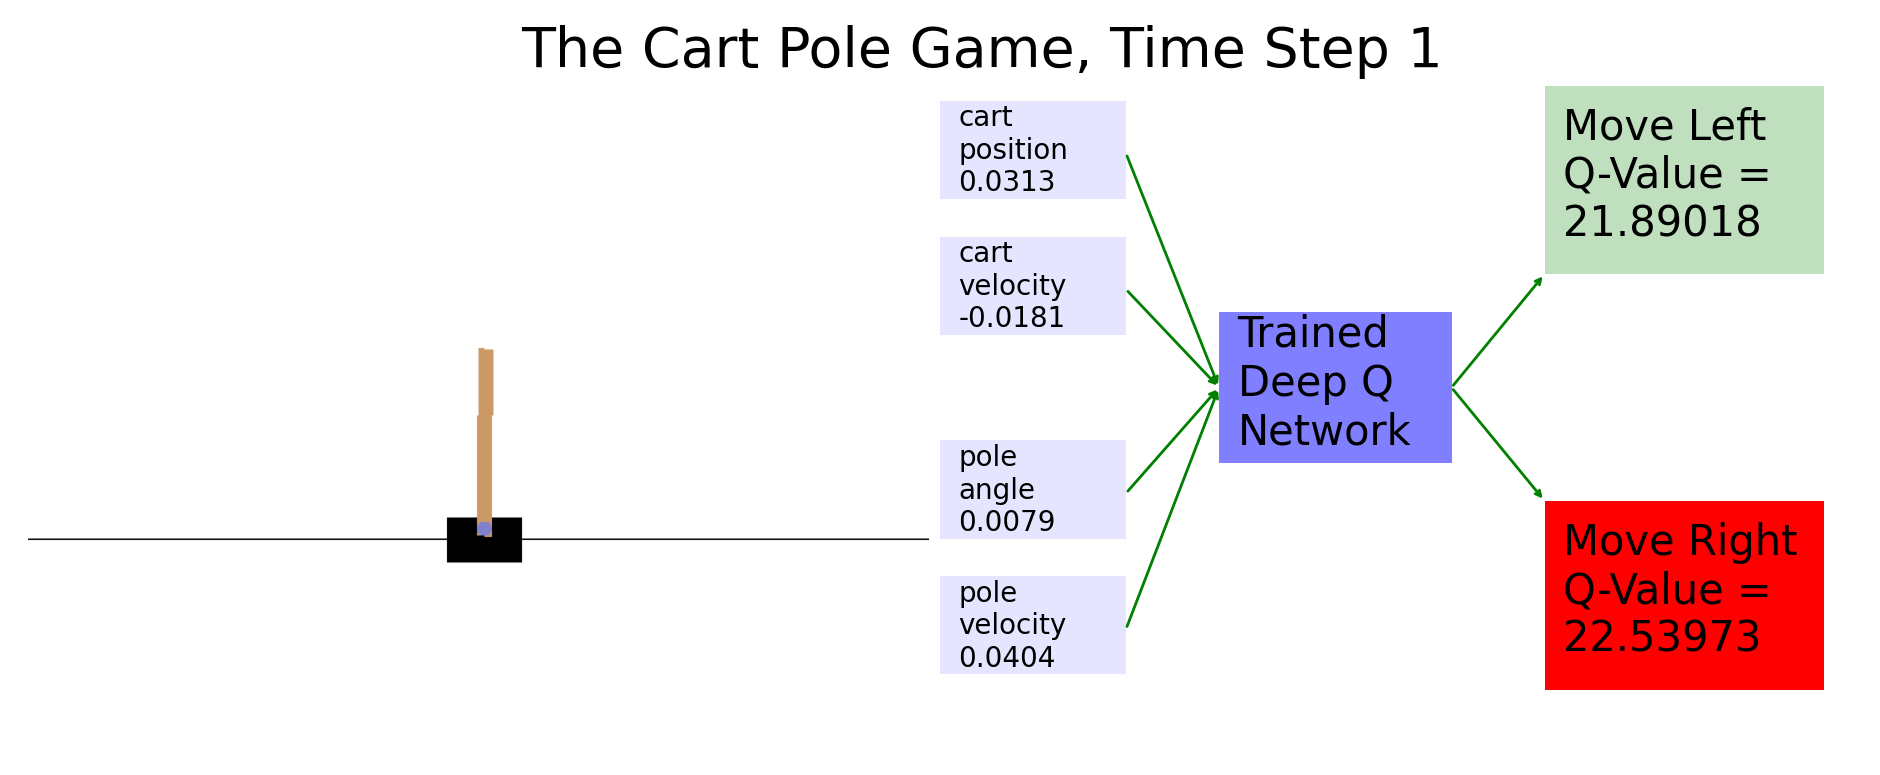

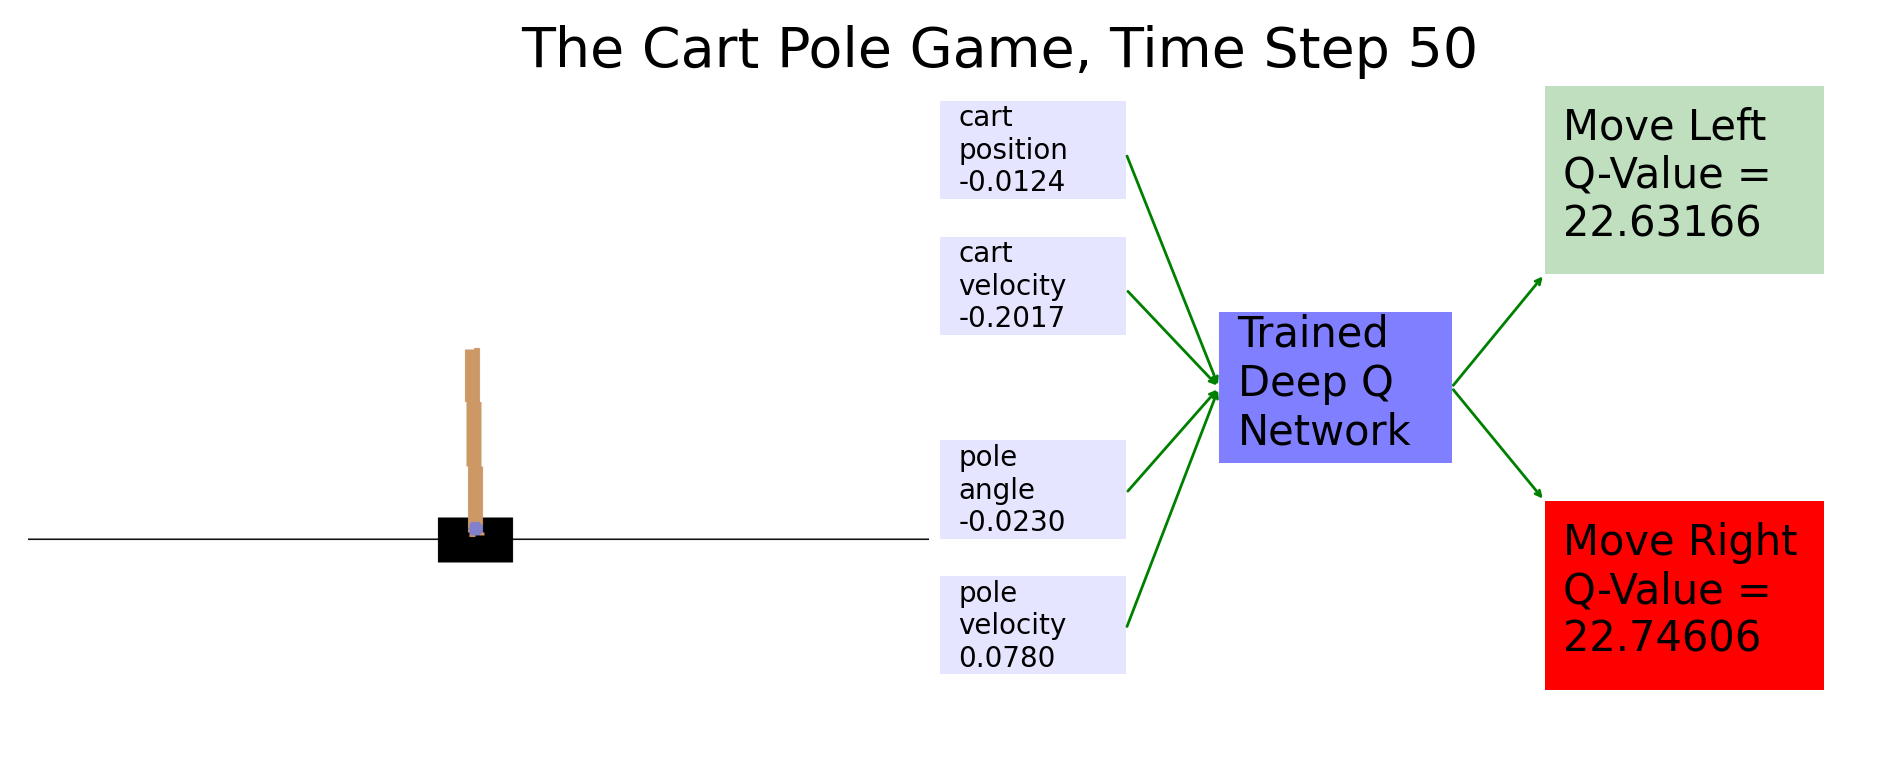

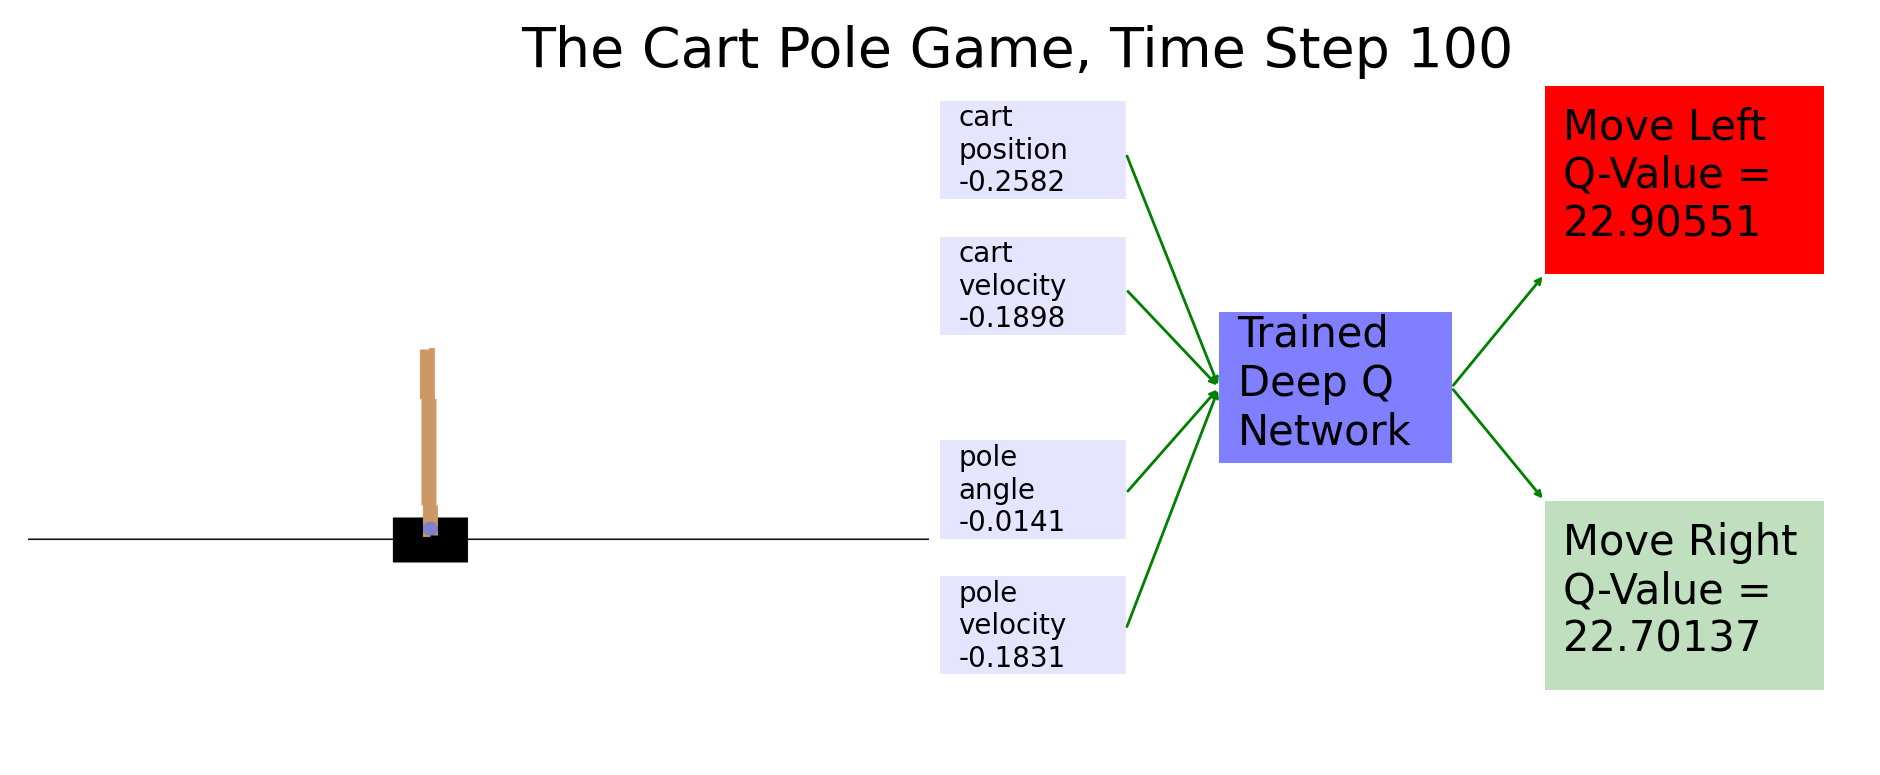

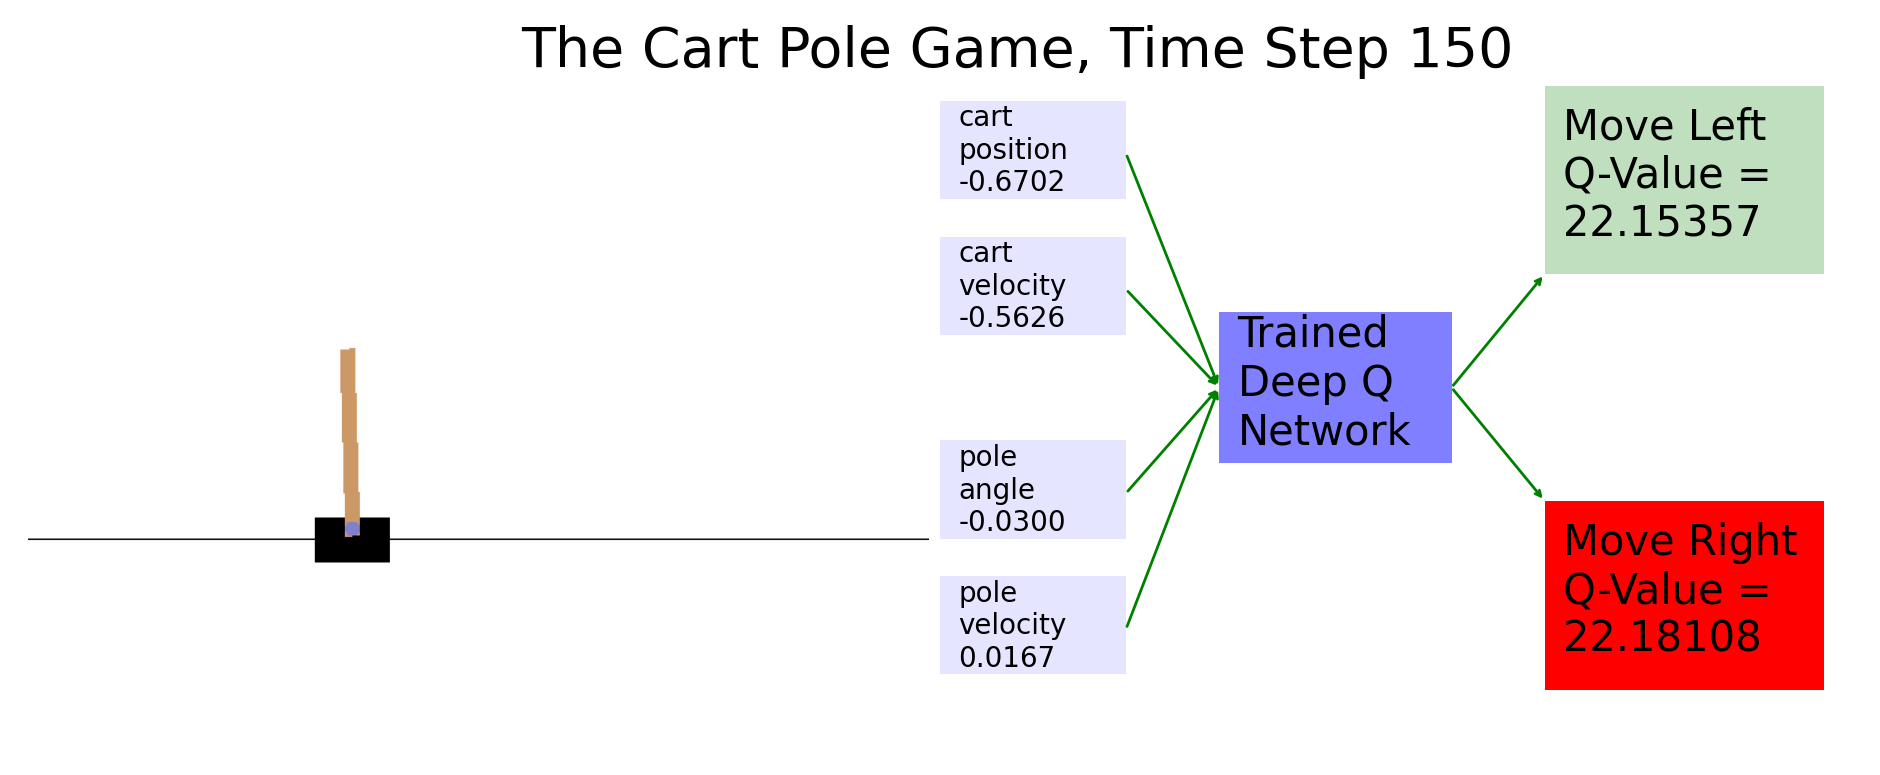

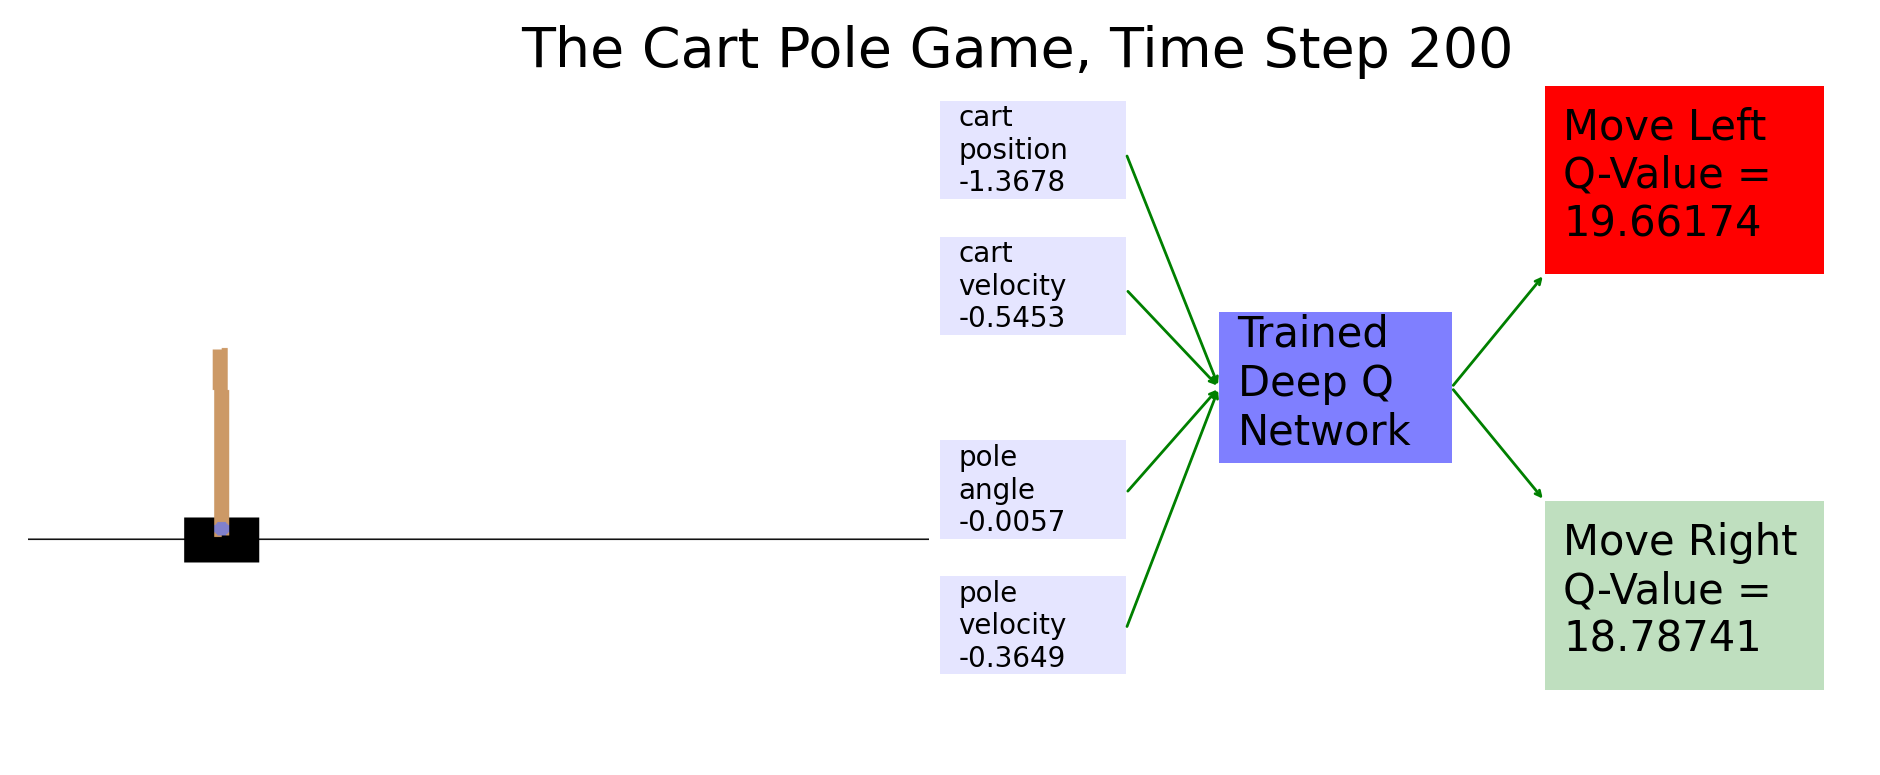

In [12]:
from utils.ch17util import save_graph

for step in [0,49,99,149,199]:
    save_graph(step,frames,states,actions,predictions)

## 17.3.2. Create A Graph for Each Time Step

In [13]:
from utils.ch17util import memory_graphs

graphs=memory_graphs(frames,states,actions,predictions)

# 17.4. An Animation and A Picture with Subplots
We'll use the *imageio* library to convert the 200 graphs into an animation, like so:

In [14]:
import imageio

imageio.mimsave('files/ch17/cartpole_deepQ.gif',graphs,duration=90)  

<img src="https://gattonweb.uky.edu/faculty/lium/ml/cartpole_deepQs.gif" />

In [15]:
subplot_frames=[]
for step in [49,99,149,199]:
    subplot_frames.append(graphs[step])

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,40),dpi=100)
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.imshow(subplot_frames[i])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.2)
plt.savefig("files/ch17/subplots_deepQ.png")

<img src="https://gattonweb.uky.edu/faculty/lium/ml/subplots_deepQ.png" />

# 17.6 Exercises

In [17]:
# answer to question 17.1
from tensorflow import keras

input_shape = [4] 
num_actions = 2

def create_q_model():
    model = keras.models.Sequential([
    keras.layers.Dense(24, activation="elu",
                       input_shape=input_shape),
    keras.layers.Dense(num_actions)
])
    return model
model = create_q_model()
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

In [18]:
# answer to question 17.2
import random
from collections import deque
import numpy as np
import tensorflow as tf
# Discount factor for past rewards
gamma = 0.95 
# batch size
batch_size = 32  
# Create a replay buffer with a maximum length of 2000
memory=deque(maxlen=2000)
# Create a running rewards list with a length of 100
running_rewards=deque(maxlen=100)

# Generate a batch
def gen_batch():
    # select a batch from the buffer memory
    samples = random.sample(memory,batch_size)
    dones = []
    frames = []
    new_frames = []
    rewards = []
    actions = []
    for sample in samples:
        frame, new_frame, action, reward, done = sample
        frames.append(frame)
        new_frames.append(new_frame)
        actions.append(action)
        if done==True:
            done=1.0          
        else: 
            done=0.0   
        dones.append(done)
        rewards.append(reward)
    frames=np.array(frames)
    new_frames=np.array(new_frames)
    dones=tf.convert_to_tensor(dones)
    return dones,frames,new_frames,rewards,actions

# Replay and update model parameters
def update_Q():
    dones,frames,new_frames,rewards,actions=gen_batch()
    # update the Q table
    preds = model.predict(new_frames, verbose=0)
    Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
    # if done=1  reset Q to  -1; important
    new_Qs = Qs * (1 - dones) - dones
    # update model parameters
    onehot = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as t:
        Q_preds=model(frames)
        # Calculate old Qs for the action taken
        old_Qs=tf.reduce_sum(tf.multiply(Q_preds,onehot),axis=1)
        # Calculate loss between new Qs and old Qs
        loss=loss_fn(new_Qs, old_Qs)
    # Update using backpropagation
    gs=t.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gs,model.trainable_variables))

import gym 
 
env = gym.make("CartPole-v0")

def play_episode():
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0    
    for timestep in range(1, 201):
        # Calculate current epsilon based on frame count
        epsilon = max(1 - episode / 500, 0.05)
        # Use epsilon-greedy for exploration
        if epsilon> np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()
        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next
        # Update Q once batch size is over 32
        if len(memory) > batch_size:
            update_Q()
        if done:
            running_rewards.append(episode_reward)
            break

for episode in range(1, 10001): 
    play_episode()
    running_reward = np.mean(np.array(running_rewards))
    if episode%20==0:
        # Log details
        template = "running reward: {:.2f} at episode {}, "
        print(template.format(running_reward, episode ))
    if running_reward>=195:
        # Log details
        template = "running reward: {:.2f} at episode {}, "
        print(template.format(running_reward, episode))
        # Periodically save the model
        model.save("files/ch17/new_deepQ.h5")
        print(f"solved at episode {episode}")
        break

In [19]:
# answer to question 17.3
# Load the trained Deep Q Network
reload=keras.models.load_model("files/ch17/new_deepQ.h5")
state=env.reset()

# We'll also save the game history for animation later
history=[]
score=0
for i in range(1,201):
    # Save the screen for later use
    frame=get_frame(deepcopy(state))
    # Predict the prob of winning 
    X_state=np.array(state).reshape(-1,4)
    prediction=reload.predict(X_state)
    # pick the action with higher prob of winning
    action=np.argmax(prediction)
    new_state, reward, done, info=env.step(action)
    history.append([frame, state, action, prediction])
    state=new_state
    score+=1
    if done:
        print(f"score is {score}")
        break
env.close()

1/1 [==============================] - 0s 22ms/step
score is 200


In [20]:
# answer to question 17.4
reload = tf.keras.models.load_model("files/ch17/new_deepQ.h5")
env = gym.make('CartPole-v0')
def test_cartpole():
    state=env.reset()
    score=0
    for i in range(1,201):
        # Predict the prob of winning 
        X_state=np.array(state).reshape(-1,4)
        prediction=reload.predict(X_state,verbose=0)
        # Pick the action with higher prob of winning
        action=np.argmax(prediction)
        new_state, reward, done, info=env.step(action)
        state=new_state
        score += 1
        if done:
            break
    return score
# Repeat the game 100 times and record results
results=[]        
for x in range(100):
    result=test_cartpole()
    results.append(result)    
#print out the average score
average_score=np.array(results).mean()
print("the average score is", average_score)
env.close()